**About** : This notebook is used to train models.

Ideas :
- https://www.kaggle.com/c/open-images-2019-instance-segmentation/discussion/110983

- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95247#latest-567841
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95233#latest-551075
- https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/95234#latest-555537

- https://www.kaggle.com/c/airbus-ship-detection/discussion/71595#latest-457550
- https://www.kaggle.com/c/airbus-ship-detection/discussion/71667#latest-558876

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/home/theo/Documents/sartorius/src


## Initialization

### Imports

In [3]:
import os
import gc
import ast
import sys
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.simplefilter("ignore", UserWarning)

In [4]:
from params import *

from utils.plots import *
from utils.metrics import iou_map
from utils.rle import rles_to_mask_fix
from utils.logger import prepare_log_folder, create_logger, save_config

from data.preparation import prepare_data
from data.dataset import SartoriusDataset
from data.transforms import define_pipelines, to_mosaic

from training.main import k_fold
from inference.post_process import *

In [5]:
import mmdet
import mmdet.models
from mmcv import Config

from mmcv.utils import build_from_cfg
from mmdet.datasets.builder import PIPELINES
from mmdet.datasets.pipelines import Compose

## Data

In [6]:
class Config:
    """
    Parameters used for training
    """
    # Images
    use_mosaic = False
    use_tta = False  # TODO
    data_config = "data/config_mosaic.py" if use_mosaic else "data/config.py"
#     data_config = "data/config_rescale.py"

In [7]:
df = prepare_data()

In [8]:
pipelines = define_pipelines(Config.data_config)

In [9]:
# dataset = SartoriusDataset(df, pipelines['test_viz'], precompute_masks=False)
dataset = SartoriusDataset(df, pipelines['val_viz'], precompute_masks=False)
# dataset = SartoriusDataset(df, pipelines['train_viz'], precompute_masks=False)

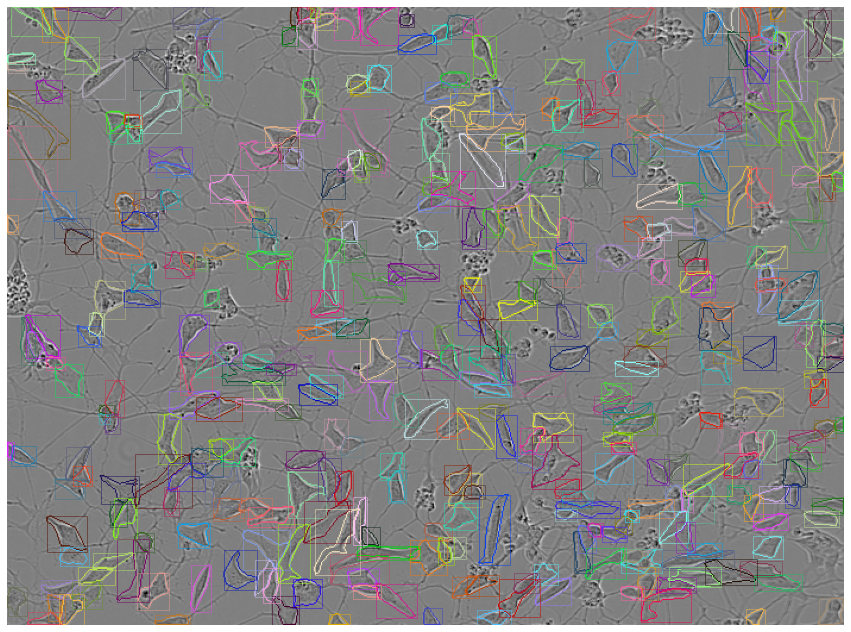

In [10]:
idx = 0

data = dataset[idx]

img = data['img']
boxes = data['gt_bboxes']

plt.figure(figsize=(15, 15))
plot_sample(img, data['gt_masks'], boxes, plotly=False)
plt.axis(False)
plt.show()

In [11]:
# sizes_, ratios_, ns = [], [], []
# for i in tqdm(range(len(dataset))):
#     data = dataset[i]
# #     img = data['img']
#     boxes = data['gt_bboxes'].astype(float)

#     sizes = np.max([boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]], 0)
#     ratios = (boxes[:, 2] - boxes[:, 0]) / (boxes[:, 3] - boxes[:, 1])
#     ratios = np.max([ratios, 1 / ratios], 0)
#     ns.append(len(boxes))
    
# #     if np.max(ratios) > 10:
#     if len(boxes) > 600:
# #     if np.max(sizes) > 256:
#         plt.figure(figsize=(15, 15))
#         plot_sample(data['img'], data['gt_masks'], boxes, plotly=False)
#         plt.axis(False)
#         plt.show()
        
    
#     sizes_.append(sizes)
#     ratios_.append(ratios)

In [12]:
dataset = SartoriusDataset(df, pipelines['train_viz'], precompute_masks=False)
# dataset = to_mosaic(Config, dataset, 'mosaic_viz')

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


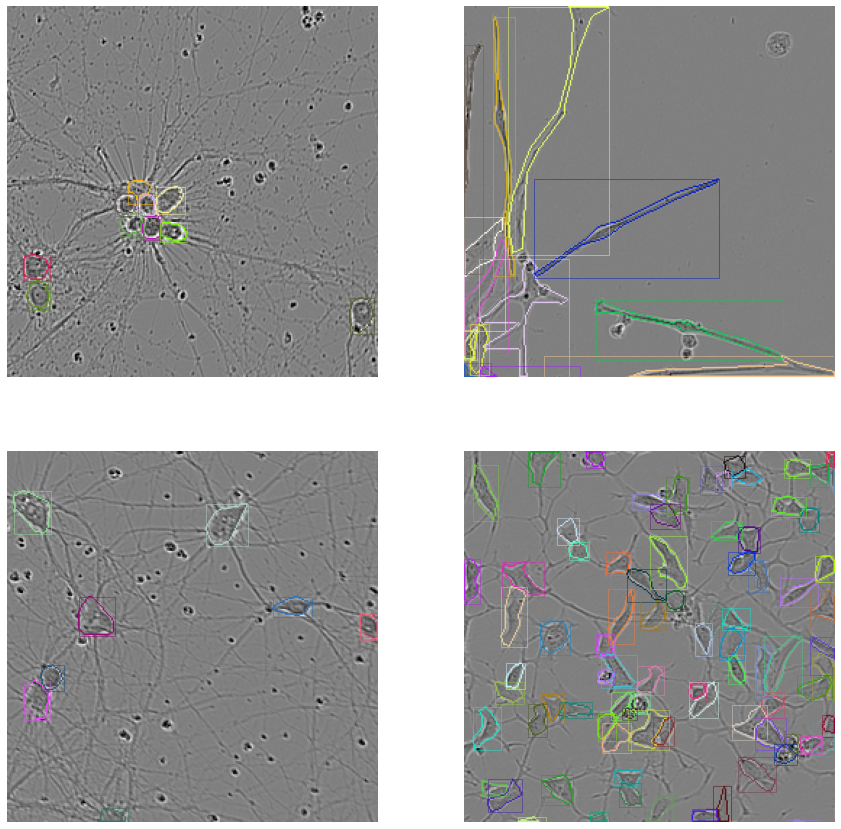

In [13]:
for _ in range(1):
    plt.figure(figsize=(15, 15))
    
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        idx = np.random.choice(len(dataset))
#         idx = 581

        data = dataset[idx]
        print(data['img'].shape)
        plot_sample(data['img'], data['gt_masks'], data['gt_bboxes'], plotly=False)
#         print(data['img'].shape)

        plt.axis(False)
    plt.show()

## Model

In [14]:
from data.loader import define_loaders
from training.optim import define_optimizer

from model_zoo.models import define_model

In [21]:
# model = define_model("model_zoo/config_cascade.py", reduce_stride=False)
model = define_model("model_zoo/config_maskrcnn.py", reduce_stride=False)

In [22]:
model.module.roi_head.mask_head

FCNMaskHead(
  (loss_mask): CrossEntropyLoss()
  (convs): ModuleList(
    (0): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (1): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (2): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
    (3): ConvModule(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activate): ReLU(inplace=True)
    )
  )
  (upsample): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (conv_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU(inplace=True)
)

In [23]:
train_dataset = SartoriusDataset(df, pipelines['train'], precompute_masks=False)
# train_dataset = to_mosaic(Config, train_dataset, 'mosaic')

test_dataset = SartoriusDataset(df, pipelines['test'], precompute_masks=False)

train_loader, val_loader = define_loaders(train_dataset, test_dataset, batch_size=1, val_bs=1, num_workers=0)

In [24]:
for batch in tqdm(train_loader):
    results = model(**batch, return_loss=True)

#     print(batch['img'].data[0].size())    
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

    break

In [25]:
model = model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader):
        for b in batch:
            batch[b] = [batch[b]]  # no tta

    #     batch['img_metas'][0].data[0][0]['scale_factor'] = np.ones(4, dtype=np.float32)
        results = model(**batch, return_loss=False, rescale=True)

        break

In [20]:
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size())
#     except:
#         pass

## Training

In [21]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    first_epoch_eval = 0
    compute_val_loss = False
    verbose_eval = 5

    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # Images
    fix = False
    use_mosaic = False
    use_tta = False  # TODO
    # data_config = "data/config_mosaic.py" if use_mosaic else "data/config.py"
    data_config = "data/config.py"

    # k-fold
    k = 5
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    name = "maskrcnn"  # "cascade"
    reduce_stride = False
    pretrain = False
    
    if pretrain and reduce_stride:
        model_config = f"model_zoo/config_{name}_stride_pretrain.py"
    elif pretrain:
        model_config = f"model_zoo/config_{name}_pretrain.py" 
    elif reduce_stride:
        model_config = f"model_zoo/config_{name}_stride.py"
    else:
        model_config = f"model_zoo/config_{name}.py"

    pretrained_folder = None
    # pretrained_folder = "../logs/2021-11-04/6/"

    # Training
    optimizer = "Adam"
    scheduler = "plateau" if optimizer == "SGD" else "linear"
    weight_decay = 0.0005 if optimizer == "SGD" else 0
    batch_size = 2 if reduce_stride else 2
    val_bs = batch_size

    epochs = 50

    lr = 5e-4
    warmup_prop = 0.01

    use_fp16 = False  # TODO

In [22]:
DEBUG = True
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

results = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------

    -> 484 training images
    -> 122 validation images
    -> 43759148 trainable parameters

Epoch 01/50 	 lr=9.9e-04	 t=32s	loss=3.107
Epoch 02/50 	 lr=9.7e-04	 t=33s	loss=2.755
Epoch 03/50 	 lr=9.5e-04	 t=33s	loss=2.554
Epoch 04/50 	 lr=9.3e-04	 t=33s	loss=2.500
Epoch 05/50 	 lr=9.1e-04	 t=59s	loss=2.447	 iou_map=0.171
Epoch 06/50 	 lr=8.9e-04	 t=33s	loss=2.391
Epoch 07/50 	 lr=8.7e-04	 t=33s	loss=2.374
Epoch 08/50 	 lr=8.5e-04	 t=33s	loss=2.363
Epoch 09/50 	 lr=8.3e-04	 t=33s	loss=2.334
Epoch 10/50 	 lr=8.1e-04	 t=58s	loss=2.296	 iou_map=0.162
Epoch 11/50 	 lr=7.9e-04	 t=33s	loss=2.325
Epoch 12/50 	 lr=7.7e-04	 t=33s	loss=2.297
Epoch 13/50 	 lr=7.5e-04	 t=33s	loss=2.323
Epoch 14/50 	 lr=7.3e-04	 t=33s	loss=2.185
Epoch 15/50 	 lr=7.1e-04	 t=58s	loss=2.294	 iou_map=0.185
Epoch 16/50 	 lr=6.9e-04	 t=33s	loss=2.230
Epoch 17/50 	 lr=6.7e-04	 t=34s	loss=2.203
Epoch 18/50 	 lr=6.5e-04	 t=33s	loss=2.186
Epoch 19/50 	 lr=6.3e-04	 t=33s	loss=2.169


In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

results = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------

    -> 484 training images
    -> 122 validation images
    -> 43759148 trainable parameters

Epoch 01/50 	 lr=1.0e-03	 t=29s	loss=2.734
Epoch 02/50 	 lr=1.0e-03	 t=53s	loss=2.722	 iou_map=0.075
Epoch 03/50 	 lr=1.0e-03	 t=31s	loss=2.573
Epoch 04/50 	 lr=1.0e-03	 t=55s	loss=2.511	 iou_map=0.130
Epoch 05/50 	 lr=1.0e-03	 t=32s	loss=2.423
Epoch 06/50 	 lr=1.0e-03	 t=55s	loss=2.413	 iou_map=0.156
Epoch 07/50 	 lr=1.0e-03	 t=32s	loss=2.346
Epoch 08/50 	 lr=1.0e-03	 t=55s	loss=2.342	 iou_map=0.148
Epoch 09/50 	 lr=1.0e-03	 t=32s	loss=2.344
Epoch 10/50 	 lr=1.0e-03	 t=56s	loss=2.284	 iou_map=0.164
Epoch 11/50 	 lr=1.0e-03	 t=32s	loss=2.266
Epoch 12/50 	 lr=1.0e-03	 t=56s	loss=2.244	 iou_map=0.178
Epoch 13/50 	 lr=1.0e-03	 t=32s	loss=2.230
Epoch 14/50 	 lr=1.0e-03	 t=56s	loss=2.230	 iou_map=0.167
Epoch 15/50 	 lr=1.0e-03	 t=32s	loss=2.208
Epoch 16/50 	 lr=1.0e-03	 t=55s	loss=2.183	 iou_map=0.182
Epoch 17/50 	 lr=1.0e-03	 t=32s	loss=2.172
Epoch 18/50

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

results = k_fold(Config, log_folder=log_folder)


-------------   Fold 1 / 5  -------------

    -> 484 training images
    -> 122 validation images
    -> 43759148 trainable parameters




Epoch 01/50 	 lr=1.0e-03	 t=95s	loss=2.889	 iou_map=0.061



Epoch 02/50 	 lr=1.0e-03	 t=104s	loss=2.817	 iou_map=0.119



Epoch 03/50 	 lr=1.0e-03	 t=103s	loss=2.630	 iou_map=0.108



Epoch 04/50 	 lr=1.0e-03	 t=105s	loss=2.535	 iou_map=0.152



Epoch 05/50 	 lr=1.0e-03	 t=106s	loss=2.464	 iou_map=0.147



Epoch 06/50 	 lr=1.0e-03	 t=105s	loss=2.425	 iou_map=0.136



Epoch 07/50 	 lr=1.0e-03	 t=103s	loss=2.397	 iou_map=0.164



Epoch 08/50 	 lr=1.0e-03	 t=103s	loss=2.370	 iou_map=0.170



Epoch 09/50 	 lr=1.0e-03	 t=103s	loss=2.324	 iou_map=0.176



Epoch 10/50 	 lr=1.0e-03	 t=104s	loss=2.307	 iou_map=0.180
